In [59]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import KFold, train_test_split
import itertools
import warnings
warnings.filterwarnings('ignore')

In [60]:
#predictors
gdp = pd.read_csv("C://Items//CS//CS 4824//Project Files//va gdp.csv")
income = pd.read_csv("C://Items//CS//CS 4824//Project Files//va median income.csv")
pop = pd.read_csv("C://Items//CS//CS 4824//Project Files//va pop.csv")
prop_val = pd.read_csv("C://Items//CS//CS 4824//Project Files//va property value.csv")
unemp = pd.read_csv("C://Items//CS//CS 4824//Project Files//va unemployment.csv")
pov = pd.read_excel("C://Items//CS//CS 4824//Project Files//va poverty rate.xlsx")
edu = pd.read_csv("C://Items//CS//CS 4824//Project Files//VA education.csv")
interest = pd.read_csv("C://Items//CS//CS 4824//Project Files//FEDFUNDS.csv")

In [61]:
#GDP
gdp.rename(columns={'VANGSP': 'VA GDP ($)'}, inplace=True)
gdp['DATE'] = pd.to_datetime(gdp['DATE'])
gdp['VA GDP ($)'] = gdp['VA GDP ($)'] * 1000000
print(gdp.head())

#Median income
income.rename(columns={'MEHOINUSVAA672N': 'Median Income ($)'}, inplace=True)
income['DATE'] = pd.to_datetime(income['DATE'])
print(income.head())

#VA population
pop.rename(columns={'VAPOP': 'VA Population'}, inplace=True)
pop['DATE'] = pd.to_datetime(pop['DATE'])
print(pop.head())

#Average bachelors edu rate
edu['DATE'] = pd.to_datetime(edu['DATE'])
edu.rename(columns={"GCT1502VA": "Adults with Bachelor's (%)"}, inplace=True)
print(edu.head())

#Poverty rate
pov['DATE'] = pd.to_datetime(pov['DATE'])
print(pov.head())

#Federal funds rate
interest['DATE'] = pd.to_datetime(interest['DATE'])
interest.rename(columns={'FEDFUNDS': 'Federal Funds Rate'}, inplace=True)
interest = interest[(interest['DATE'].dt.month == 1) & (interest['DATE'].dt.day == 1)]
print(interest.head())

#fix property val df and unemp df to be on a yearly basis
prop_val_fixed = prop_val[prop_val['DATE'].str.endswith('-01-01')]
prop_val_fixed['DATE'] = pd.to_datetime(prop_val['DATE'])
prop_val_fixed = prop_val_fixed.reset_index(drop=True)
prop_val_fixed.rename(columns={"VAUCSFRCONDOSMSAMID" : "ZVHI Value ($)"}, inplace = True)
print("\n", prop_val_fixed.head(), "\n")

#unemployment rate
unemp_fixed = unemp[unemp['DATE'].str.endswith('-01-01')]
unemp_fixed['DATE'] = pd.to_datetime(unemp['DATE'])
unemp_fixed = unemp_fixed.reset_index(drop=True)
unemp_fixed.rename(columns={"LAUST510000000000003A" : "Unemployment Rate (%)"}, inplace=True)
print(unemp_fixed.head())

interest['DATE'] = pd.to_datetime(interest['DATE'])
fixed_interest = interest[(interest['DATE'].dt.month == 1) & (interest['DATE'].dt.day == 1)]
fixed_interest = fixed_interest.reset_index(drop=True)
print(fixed_interest.head())

        DATE    VA GDP ($)
0 2000-01-01  2.686087e+11
1 2001-01-01  2.856634e+11
2 2002-01-01  2.949291e+11
3 2003-01-01  3.110931e+11
4 2004-01-01  3.318158e+11
        DATE  Median Income ($)
0 2000-01-01              78650
1 2001-01-01              81940
2 2002-01-01              79950
3 2003-01-01              86440
4 2004-01-01              78720
        DATE  VA Population
0 2000-01-01       7105.817
1 2001-01-01       7198.362
2 2002-01-01       7286.873
3 2003-01-01       7366.977
4 2004-01-01       7475.575
        DATE  Adults with Bachelor's (%)
0 2006-01-01                        32.7
1 2007-01-01                        33.6
2 2008-01-01                        33.7
3 2009-01-01                        34.0
4 2010-01-01                        34.2
        DATE  Poverty Rate
0 2000-01-01           9.2
1 2001-01-01           9.3
2 2002-01-01           9.9
3 2003-01-01           9.0
4 2004-01-01           9.5
         DATE  Federal Funds Rate
0  2000-01-01                5.45
12

In [62]:
#response
tax_revenue = pd.read_csv("C://Items//CS//CS 4824//Project Files//va total tax.csv")
tax_revenue['DATE'] = pd.to_datetime(tax_revenue['DATE'])
tax_revenue.rename(columns={"QTAXTOTALQTAXCAT3VANO" : "VA Total Tax Revenue ($)"}, inplace=True)
tax_revenue['VA Total Tax Revenue ($)'] = tax_revenue['VA Total Tax Revenue ($)'] * 1000000

datasets = [gdp, income, pop, prop_val_fixed, unemp_fixed, pov, interest, edu]
for dataset in datasets:
    tax_revenue = tax_revenue.merge(dataset, on='DATE', how='inner')

X = tax_revenue.drop(columns=['DATE', 'VA Total Tax Revenue ($)'])
y = tax_revenue['VA Total Tax Revenue ($)']

In [63]:
tax_revenue

,DATE,VA Total Tax Revenue ($),VA GDP ($),Median Income ($),VA Population,ZVHI Value ($),Unemployment Rate (%),Poverty Rate,Federal Funds Rate,Adults with Bachelor's (%)
0,2006-01-01,3.831000e+09,3.764294e+11,83040,7673.725,254805.380999,3.3,9.6,4.29,32.7
1,2007-01-01,3.983000e+09,3.915955e+11,83860,7751.000,264087.523907,3.3,9.9,5.25,33.6
2,2008-01-01,4.064000e+09,4.021578e+11,84760,7833.496,255080.907259,4.3,10.2,3.94,33.7
3,2009-01-01,3.255000e+09,4.099353e+11,83060,7925.937,231059.782268,6.8,10.5,0.15,34.0
4,2010-01-01,3.223000e+09,4.254908e+11,81750,8024.004,220102.400293,7.3,11.1,0.11,34.2
5,2011-01-01,3.697000e+09,4.336837e+11,82250,8102.437,216049.270880,6.6,11.5,0.17,35.1
6,2012-01-01,3.925000e+09,4.450085e+11,83290,8187.456,209749.160200,5.9,11.7,0.08,35.5
7,2013-01-01,4.077000e+09,4.569116e+11,83910,8255.861,219128.611646,5.6,11.7,0.14,36.1
8,2014-01-01,4.157000e+09,4.656017e+11,83050,8315.430,228737.780697,5.1,11.8,0.07,36.7
9,2015-01-01,4.265000e+09,4.855409e+11,77240,8367.303,233701.316899,4.4,11.2,0.11,37.0


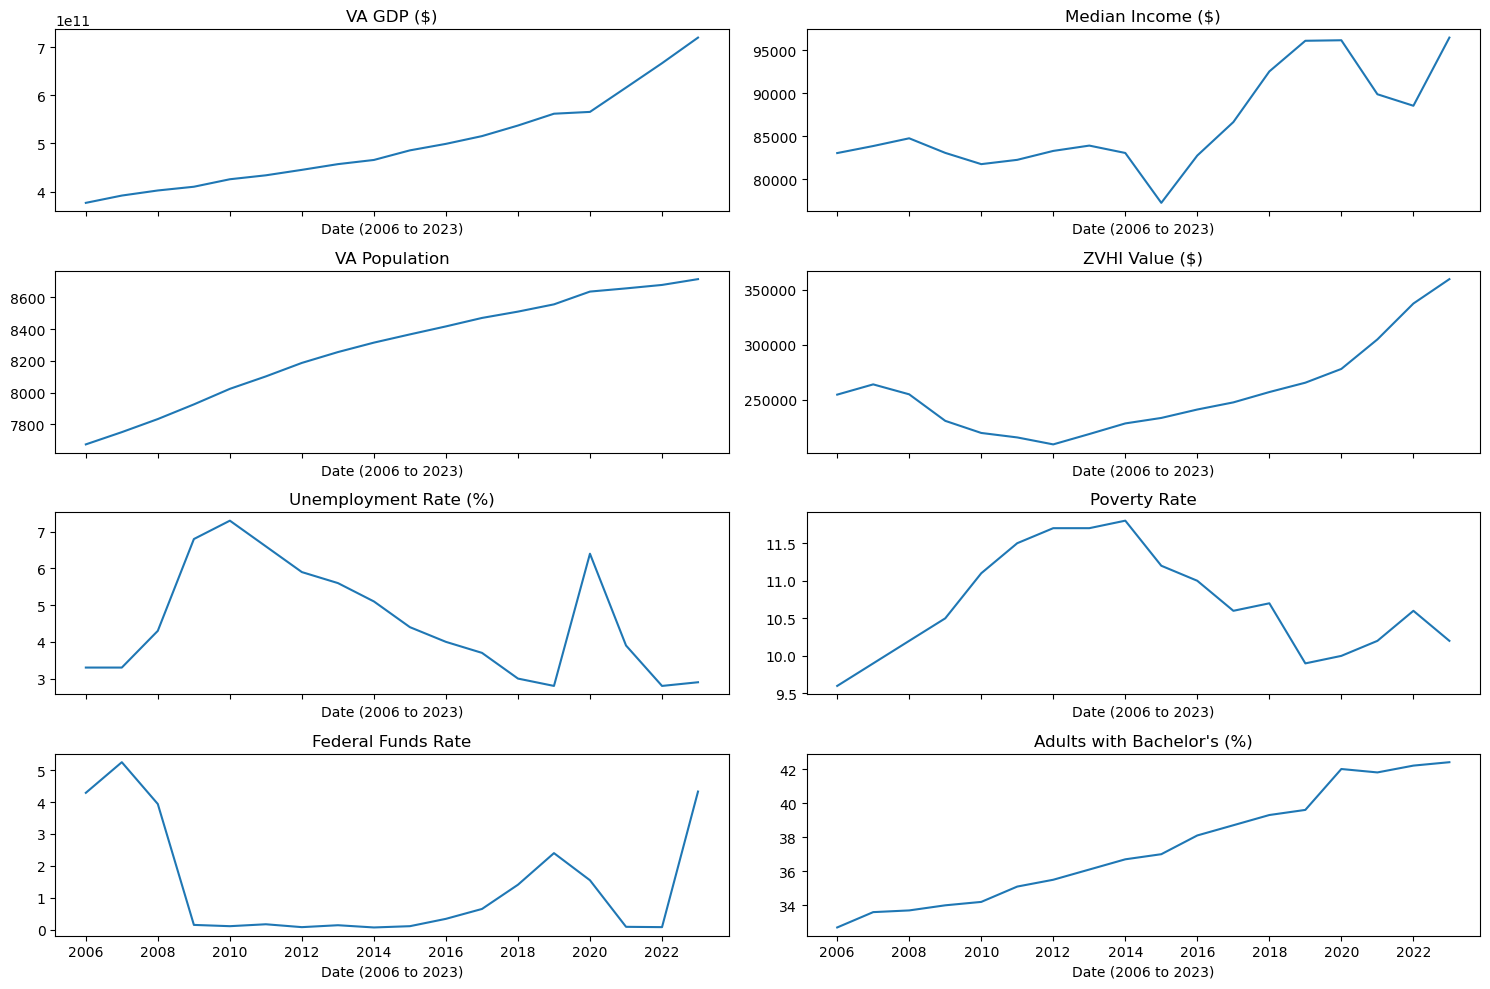

In [64]:
columns_to_plot = tax_revenue.columns.drop(['DATE', 'VA Total Tax Revenue ($)'])
fig, axes = plt.subplots(4, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    axes[i].plot(tax_revenue['DATE'], tax_revenue[column])
    axes[i].set_title(column)
    axes[i].set_xlabel("Date (2006 to 2023)")

plt.tight_layout()
plt.show()

# 70-30 Split Model

In [65]:
#TOTAL MODEL
dates = tax_revenue['DATE']
model = RandomForestRegressor(random_state = 1)
kf = KFold(n_splits = 10, shuffle = True, random_state = 1)

actual = []
predicted = []
dates_for_plot = []

mae_scores = []
mape_scores = []
rmse_scores = []

for train_index, test_index in kf.split(X):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train =  y.iloc[train_index] 
    y_test = y.iloc[test_index]
    dates_test = dates.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #metrics
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    mape_scores.append(mean_absolute_percentage_error(y_test, y_pred))
    rmse_scores.append(mean_squared_error(y_test, y_pred, squared = False))

    actual.extend(y_test)
    predicted.extend(y_pred)
    dates_for_plot.extend(dates_test)

print("Mean Absolute Error:", np.mean(mae_scores))
print("Mean Absolute Percentage Error:", np.mean(mape_scores))
print("Root Mean Squared Error", np.mean(rmse_scores))

Mean Absolute Error: 304391000.0
Mean Absolute Percentage Error: 0.05825485716248663
Root Mean Squared Error 358286125.9714891


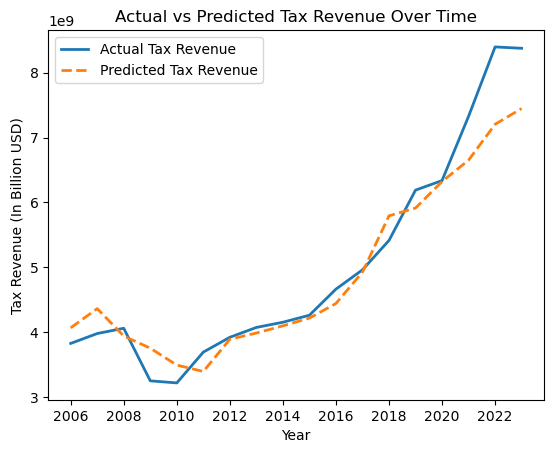

In [70]:
#putting into df to easily sort by date
results_df = pd.DataFrame({
    'DATE': dates_for_plot,
    'Actual': actual,
    'Predicted': predicted
}).sort_values(by='DATE')

plt.plot(results_df['DATE'], results_df['Actual'], label='Actual Tax Revenue', linewidth=2)
plt.plot(results_df['DATE'], results_df['Predicted'], label='Predicted Tax Revenue', linestyle='--', linewidth=2)
plt.xlabel('Year')
plt.ylabel('Tax Revenue (In Billion USD)')
plt.title('Actual vs Predicted Tax Revenue Over Time')
plt.legend()

# Testing Different Hyperparameters

In [33]:
#Testing different hyperparams
n_s = np.linspace(50, 300, 6, dtype=int)
max_depth = np.linspace(5, 50, 10, dtype=int)
min_split = np.linspace(2, 20, 5, dtype=int)

results = []

kf = KFold(n_splits=10, shuffle=True, random_state=1)

for n in n_s:
    for depth in max_depth:
        for split in min_split:
            model = RandomForestRegressor(
                n_estimators=n,
                max_depth=depth,
                min_samples_split=split,
                random_state=1
            )

            #storing local metrics
            mae_scores = []
            mape_scores = []
            rmse_scores = []
            
            for train_index, test_index in kf.split(X):
                X_train = X.iloc[train_index]
                X_test = X.iloc[test_index]
                y_train = y.iloc[train_index]
                y_test =  y.iloc[test_index]
                
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                
                mae_scores.append(mean_absolute_error(y_test, y_pred))
                mape_scores.append(mean_absolute_percentage_error(y_test, y_pred))
                rmse_scores.append(mean_squared_error(y_test, y_pred, squared=False))
            
            results.append({
                'n_estimators': n,
                'max_depth': depth,
                'min_samples_split': split,
                'MAE': np.mean(mae_scores),
                'MAPE': np.mean(mape_scores),
                'RMSE': np.mean(rmse_scores)
            })

results_df = pd.DataFrame(results)

# Output the best combination
best_combination = results_df.loc[results_df['RMSE'].idxmin()]
print("Best Hyperparameter Combination: \n", best_combination)

Best Hyperparameter Combination:
n_estimators         1.500000e+02
max_depth            1.000000e+01
min_samples_split    2.000000e+00
MAE                  2.965130e+08
MAPE                 5.611594e-02
RMSE                 3.514995e+08
Name: 105, dtype: float64


## Running the best hyperparameters

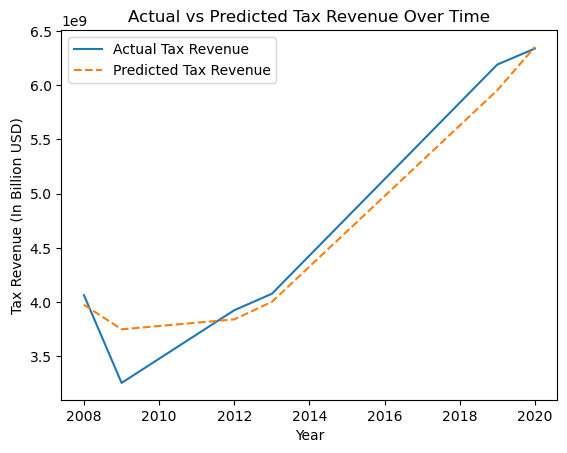

In [ ]:
#70-30
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X, y, tax_revenue['DATE'], test_size=0.3, random_state=1, shuffle=True)
kf = KFold(n_splits=10, shuffle=True, random_state=1)

#using calculated best params
model = RandomForestRegressor(
    n_estimators=150,
    max_depth=10,
    min_samples_split=2,
    random_state=1
)

actual_kfold = []
predicted_kfold = []
dates_kfold = []
mae_scores = []
mape_scores = []
rmse_scores = []

for train_index, val_index in kf.split(X_train):
    X_train_fold = X_train.iloc[train_index]
    X_val_fold = X_train.iloc[val_index]
    y_train_fold = y_train.iloc[train_index]
    y_val_fold = y_train.iloc[val_index]
    dates_val_fold = dates_train.iloc[val_index]

    model.fit(X_train_fold, y_train_fold)
    y_val_pred = model.predict(X_val_fold)

    mae_scores.append(mean_absolute_error(y_val_fold, y_val_pred))
    mape_scores.append(mean_absolute_percentage_error(y_val_fold, y_val_pred))
    rmse_scores.append(mean_squared_error(y_val_fold, y_val_pred, squared=False))

    actual_kfold.extend(y_val_fold)
    predicted_kfold.extend(y_val_pred)
    dates_kfold.extend(dates_val_fold)

model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

results_df = pd.DataFrame({
    'DATE': dates_test,
    'Actual': y_test,
    'Predicted': y_test_pred
}).sort_values(by='DATE')

plt.plot(results_df['DATE'], results_df['Actual'], label='Actual Tax Revenue')
plt.plot(results_df['DATE'], results_df['Predicted'], label='Predicted Tax Revenue', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Tax Revenue (In Billion USD)')
plt.title('Actual vs Predicted Tax Revenue Over Time')
plt.legend()

# Testing Withheld Data

In [67]:
#training to 2014, testing to 2023
train_data = tax_revenue[(tax_revenue['DATE'] >= '2006-01-01') & (tax_revenue['DATE'] <= '2013-12-31')]
test_data = tax_revenue[(tax_revenue['DATE'] >= '2014-01-01') & (tax_revenue['DATE'] <= '2023-12-31')]

X_train = train_data.drop(columns=['DATE', 'VA Total Tax Revenue ($)'])
y_train = train_data['VA Total Tax Revenue ($)']
X_test = test_data.drop(columns=['DATE', 'VA Total Tax Revenue ($)'])
y_test = test_data['VA Total Tax Revenue ($)']
dates_test = test_data['DATE']

model = RandomForestRegressor(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae_score = mean_absolute_error(y_test, y_pred)
mape_score = mean_absolute_percentage_error(y_test, y_pred)
rmse_score = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error:", mae_score)
print("Mean Absolute Percentage Error:", mape_score)
print("Root Mean Squared Error:", rmse_score)

Mean Absolute Error: 2072926000.0
Mean Absolute Percentage Error: 0.3065875994497554
Root Mean Squared Error: 2528419719.1368365


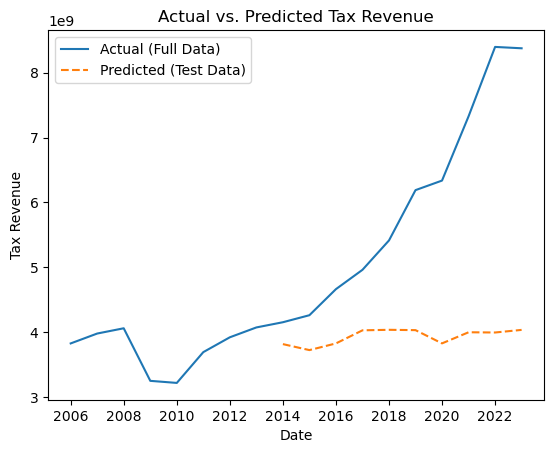

In [69]:
plt.plot(tax_revenue['DATE'], tax_revenue['VA Total Tax Revenue ($)'], label="Actual (Full Data)", linestyle='-')
plt.plot(dates_test, y_pred, label="Predicted (Test Data)", linestyle='--')
plt.xlabel("Date")
plt.ylabel("Tax Revenue")
plt.title("Actual vs. Predicted Tax Revenue")
plt.legend()

In [86]:
np.average(tax_revenue["VA Total Tax Revenue ($)"])

np.float64(5008000000.0)